In [60]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# !pip install geopandas --quiet
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import scipy
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
# !pip install rasterio --quiet
import rasterio
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import math
from datetime import datetime

In [61]:
os.getcwd()
os.chdir('/home/shoyo/Desktop')
os.listdir( os.getcwd() )

['logs',
 'SOC_LonLatYearLC.csv',
 'Precipitation2020',
 'RF.ipynb',
 'SOC.csv',
 'python3-ipykernel_6.17.0-1_all(2).deb',
 'oldScript',
 '.ipynb_checkpoints',
 '.xdp_LSTM.ipynb.4SXV41',
 'LSTM',
 'DataPrep.ipynb',
 'oldCSV',
 'LSTM.ipynb',
 'Precipitation2021']

In [62]:
# Set seed
def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [63]:
csv_path = os.getcwd() + '/SOC.csv'
df1 = pd.read_csv(csv_path)
df2 = df1[ (df1.EVI<-1) | (df1.EVI>1) ]

df = pd.DataFrame(columns=df1.columns)
for i in range(len(df1)):
    lat = df1.loc[i, 'latitude']
    lon = df1.loc[i, 'longitude']
    if not ((df2['latitude'] == lat) & (df2['longitude'] == lon)).any():
        # df = pd.concat([df, df1.loc[i]]) 
        df.loc[len(df)] = df1.iloc[i]
        # df = df.append(df1.loc[i]) 

df = df.drop(columns=['latitude', 'longitude', 'year', 'LC'])
df

,SOC,elev,slope,aspect,roughness,twi,SR_B2-1,SR_B3-1,SR_B4-1,SR_B5-1,...,SR_B4,SR_B5,SR_B6,SR_B7,EVI,ST_B10,VV,VH,VV/VH,prec
0,6.84225,1641,1.311631,47.303562,15.660496,-0.83046,0.166671,0.1916,0.207811,0.371354,...,0.310084,0.421857,0.312834,0.240069,0.20156,278.537831,0.100637,0.016779,5.997724,7.733378
1,5.94385,1634,5.549156,61.341667,12.340887,-1.442346,0.372605,0.421583,0.433325,0.565792,...,0.173285,0.317,0.238625,0.19193,0.208251,278.115705,0.081446,0.023201,3.510426,7.733378
2,4.4506,1626,5.39333,63.41954,13.694862,-1.242844,0.27762,0.305148,0.311541,0.404409,...,0.12505,0.309575,0.20645,0.191408,0.178394,279.735847,0.077992,0.012462,6.258336,7.733378
3,7.10625,1652,1.854871,54.527138,8.628444,-1.174888,0.367902,0.366472,0.369855,0.448093,...,0.252719,0.403735,0.277304,0.221039,0.216093,276.727989,0.066324,0.01395,4.754431,7.733378
4,7.06505,1629,3.340624,22.484619,12.107599,1.348318,0.242035,0.272423,0.284,0.40731,...,0.232974,0.373843,0.288648,0.22812,0.184308,274.041426,0.073882,0.013287,5.560403,7.733378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,11.6996,1281,5.845603,170.821472,12.704651,-1.521508,0.048146,0.138291,0.110736,0.371326,...,0.104879,0.425515,0.260776,0.17279,0.403028,262.857664,0.238391,0.047586,5.009638,19.454737
2250,17.2755,1280,2.073029,302.341278,13.376803,-1.125369,0.268132,0.291535,0.300802,0.484832,...,0.124349,0.423535,0.247604,0.167441,0.405969,263.734386,0.153898,0.036015,4.273174,19.454737
2251,16.5506,1273,1.854334,275.882629,16.946148,-1.232709,0.238762,0.297447,0.29764,0.49025,...,0.199644,0.465555,0.32404,0.250766,0.416291,263.725841,0.122215,0.025671,4.760748,19.454737
2252,11.2663,1269,3.818481,321.026031,11.025431,-1.183926,0.27674,0.27509,0.29247,0.469845,...,0.292649,0.484736,0.371766,0.263182,0.375307,263.180667,0.104044,0.019337,5.380625,19.454737


In [64]:
df = df.sample(frac=1, random_state=42)
n = len(df)

# scaler = StandardScaler()
# train_df = scaler.fit_transform(df[0:int(n*0.8)])
# val_df = scaler.fit_transform(df[int(n*0.8):int(n*0.9)])
# test_df = scaler.fit_transform(df[int(n*0.9):])
# Xtrain = train_df[:,1:]
# Ytrain = train_df[:,0]
# Xval = val_df[:,1:]
# Yval = val_df[:,0]
# Xtest = test_df[:,1:]
# Ytest = test_df[:,0]

train_df = df[0:int(n*0.8)]
val_df = df[int(n*0.8):int(n*0.9)]
test_df = df[int(n*0.9):]
Xtrain = train_df.iloc[:,1:]
Ytrain = train_df.iloc[:,0]
Xval = val_df.iloc[:,1:]
Yval = val_df.iloc[:,0]
Xtest = test_df.iloc[:,1:]
Ytest = test_df.iloc[:,0]

# train_df = scaler.fit_transform(df[:11760])
# val_df = scaler.fit_transform(df[11760:(11760+1464)])
# test_df = scaler.fit_transform(df[(11760+1464):])

In [65]:
df.apply(['mean', 'median', 'max', 'min', 'std', 'skew', 'count']).transpose()

,mean,median,max,min,std,skew,count
SOC,10.216712,7.784500,119.511800,1.612800,10.852877,4.491025,2254.0
elev,1020.733807,1111.000000,2022.000000,-3.000000,481.673781,-0.659139,2254.0
slope,3.358222,2.624617,44.433758,0.000000,3.346664,4.175273,2254.0
aspect,167.385410,159.216858,359.977112,0.032219,105.642955,0.204287,2254.0
roughness,8.799856,4.935846,157.365005,0.215358,12.780057,4.566025,2254.0
twi,0.680638,0.221288,10.531526,-3.706729,2.029255,1.504489,2254.0
SR_B2-1,0.194438,0.142877,0.696858,0.003115,0.149251,0.864834,2254.0
SR_B3-1,0.240076,0.204504,0.676673,0.033406,0.130167,0.803528,2254.0
SR_B4-1,0.255870,0.222276,0.659952,0.039305,0.131604,0.694178,2254.0
SR_B5-1,0.395033,0.388541,0.698562,0.095735,0.100562,0.290040,2254.0


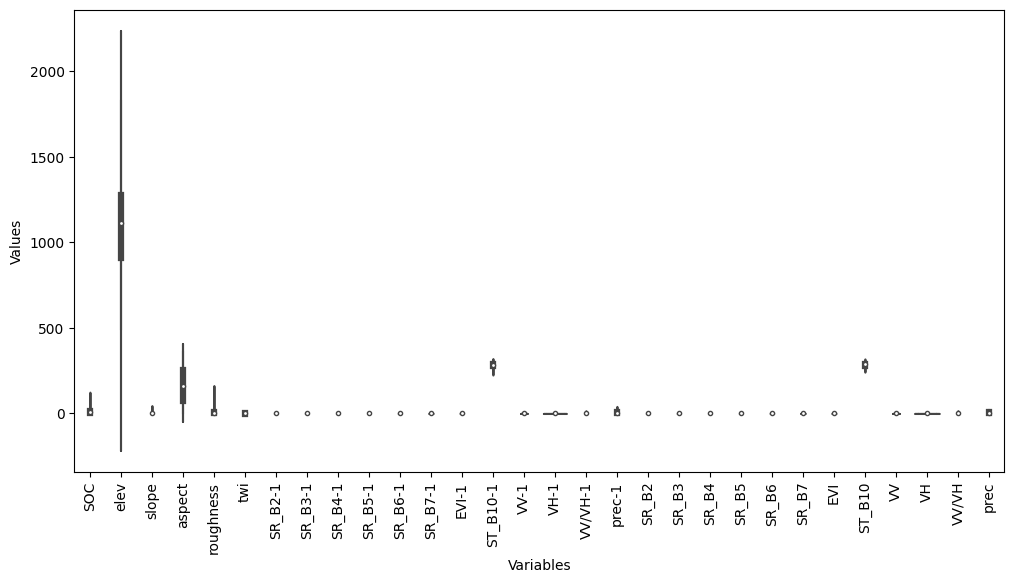

In [66]:
# df_std = pd.DataFrame(train_df).melt(var_name='Column', value_name='Normalized')
df_std = train_df.melt(var_name='Variables', value_name='Values')
df_std['Values'] = pd.to_numeric(df_std['Values'], errors='coerce')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Variables', y='Values', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [67]:
# Set grid search parameters
n_trees_range = [10, 50, 100, 200, 300, 400, 500, 600]
min_samples_range = [2, 5, 10, 15, 20, 25, 30]

# prepare matrix for storing the matrics reached on the validation set per parameter combination
rmse_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
mae_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
rsquare_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
oob_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])
time_paramsearch = np.ndarray([len(n_trees_range), len(min_samples_range)])

# Perform the parameter searching and keep track of performance
for n_trees_index, n_trees in enumerate(n_trees_range):
    for min_leaves_index, min_samples in enumerate(min_samples_range):
        print(f"N trees: {n_trees}, Min. samples samples per leaf: {min_samples}")
        
        # Initialize the random forest classifier
        model = RandomForestRegressor(n_estimators=n_trees, min_samples_split=min_samples, oob_score=True, random_state=42)
        
        # Fit the classifier to the training data/labels
        start = datetime.now()
        model.fit(Xtrain, Ytrain)
        end = datetime.now()
        time_taken = float(f"{(end - start).seconds}.{round((end - start).microseconds, 2)}")

        # Use the model to predict all of the validation pixels
        predictions = model.predict(Xval)

        # Calculate the accuracy of the predicted labels vs the ground truth labels
        rmse = math.sqrt( mean_squared_error(predictions, Yval) )
        mae = mean_absolute_error(predictions, Yval)
        rsquared = r2_score(predictions, Yval)
        oob = model.oob_score_

        # Store accuracies and time taken for this parameter combination
        rmse_paramsearch[n_trees_index, min_leaves_index] = round(rmse, 2)
        mae_paramsearch[n_trees_index, min_leaves_index] = round(mae, 2)
        rsquare_paramsearch[n_trees_index, min_leaves_index] = round(rsquared, 2)
        oob_paramsearch[n_trees_index, min_leaves_index] = round(oob, 2)
        time_paramsearch[n_trees_index, min_leaves_index] = round(time_taken, 2)

N trees: 10, Min. samples samples per leaf: 2


/home/shoyo/carbon/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


N trees: 10, Min. samples samples per leaf: 5


/home/shoyo/carbon/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


N trees: 10, Min. samples samples per leaf: 10


/home/shoyo/carbon/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


N trees: 10, Min. samples samples per leaf: 15


/home/shoyo/carbon/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


N trees: 10, Min. samples samples per leaf: 20


/home/shoyo/carbon/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


N trees: 10, Min. samples samples per leaf: 25


/home/shoyo/carbon/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


N trees: 10, Min. samples samples per leaf: 30


/home/shoyo/carbon/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:583: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


N trees: 50, Min. samples samples per leaf: 2
N trees: 50, Min. samples samples per leaf: 5
N trees: 50, Min. samples samples per leaf: 10
N trees: 50, Min. samples samples per leaf: 15
N trees: 50, Min. samples samples per leaf: 20
N trees: 50, Min. samples samples per leaf: 25
N trees: 50, Min. samples samples per leaf: 30
N trees: 100, Min. samples samples per leaf: 2
N trees: 100, Min. samples samples per leaf: 5
N trees: 100, Min. samples samples per leaf: 10
N trees: 100, Min. samples samples per leaf: 15
N trees: 100, Min. samples samples per leaf: 20
N trees: 100, Min. samples samples per leaf: 25
N trees: 100, Min. samples samples per leaf: 30
N trees: 200, Min. samples samples per leaf: 2
N trees: 200, Min. samples samples per leaf: 5
N trees: 200, Min. samples samples per leaf: 10
N trees: 200, Min. samples samples per leaf: 15
N trees: 200, Min. samples samples per leaf: 20
N trees: 200, Min. samples samples per leaf: 25
N trees: 200, Min. samples samples per leaf: 30
N tre

/tmp/ipykernel_2101366/606754388.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rmse.set_xticklabels(n_trees_labels)
/tmp/ipykernel_2101366/606754388.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rmse.set_yticklabels(min_leaves_labels)
/tmp/ipykernel_2101366/606754388.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mae.set_xticklabels(n_trees_labels)
/tmp/ipykernel_2101366/606754388.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_mae.set_yticklabels(min_leaves_labels)
/tmp/ipykernel_2101366/606754388.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rsquared.set_xticklabels(n_trees_labels)
/tmp/ipykernel_2101366/606754388.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_rsquared.set_yticklabels(min_leaves_labels)
/tmp/ipykernel_2101366/606754388.py:31: Use

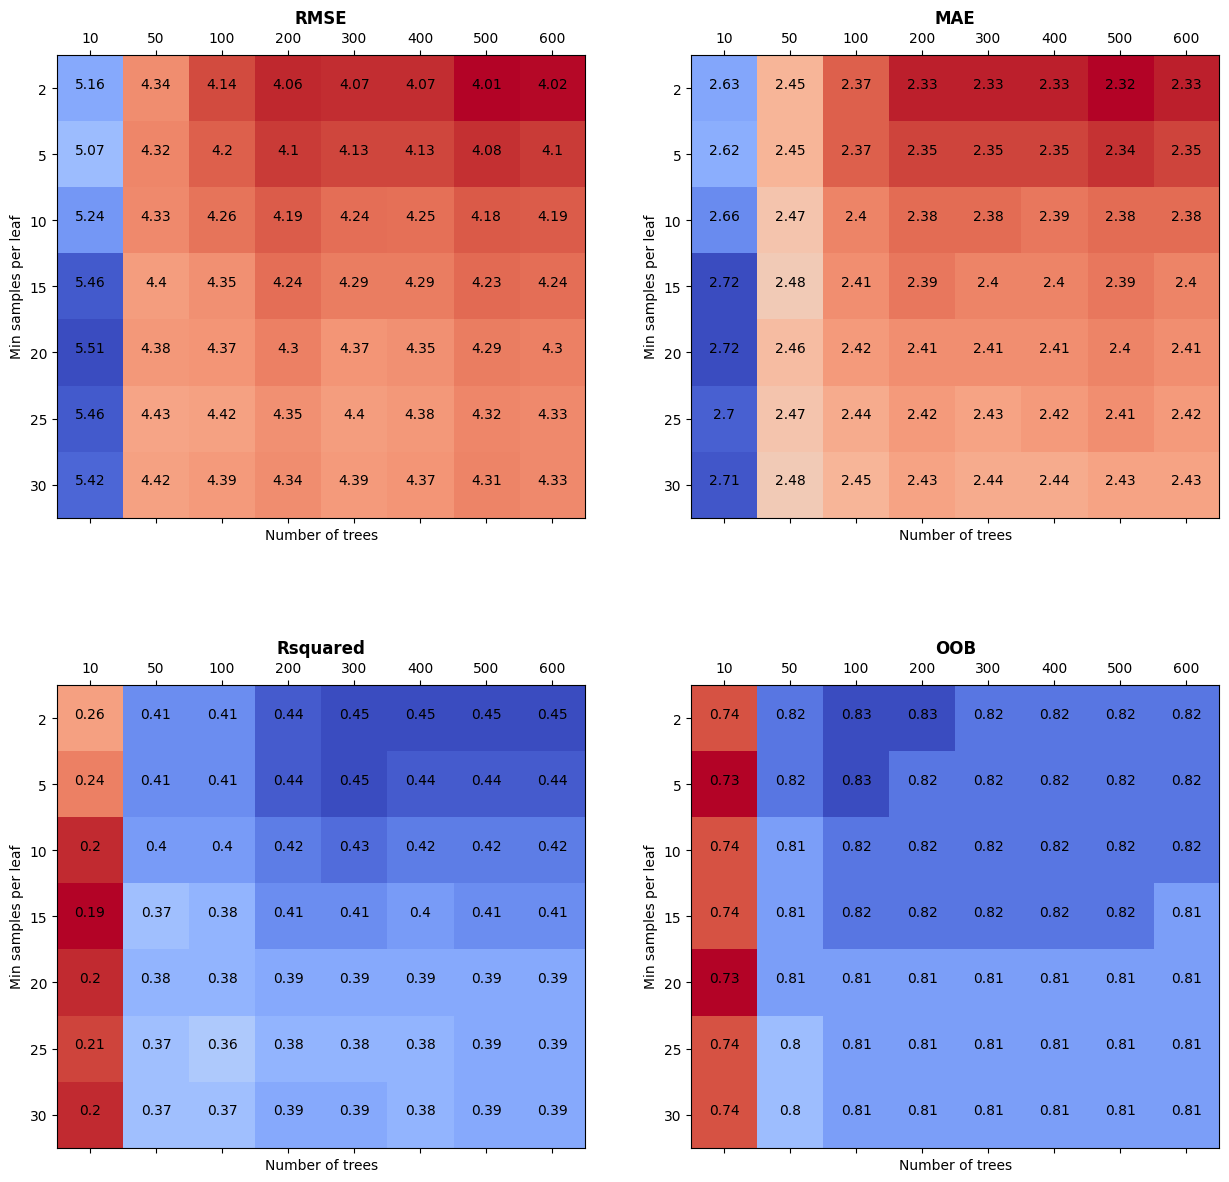

In [68]:
# Plot the validation results
n_trees_labels = [0] + n_trees_range
min_leaves_labels = [0] + min_samples_range 

fig, ((ax_rmse, ax_mae), (ax_rsquared, ax_oob)) = plt.subplots(2, 2, figsize=(15,15))

## Plot RMSE
ax_rmse.set_title("RMSE", weight='bold')
ax_rmse.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_rmse.set_xticklabels(n_trees_labels)
ax_rmse.set_yticklabels(min_leaves_labels)
ax_rmse.matshow(rmse_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot MAE
ax_mae.set_title("MAE", weight='bold')
ax_mae.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_mae.set_xticklabels(n_trees_labels)
ax_mae.set_yticklabels(min_leaves_labels)
ax_mae.matshow(mae_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot Rsquared
ax_rsquared.set_title("Rsquared", weight='bold')
ax_rsquared.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_rsquared.set_xticklabels(n_trees_labels)
ax_rsquared.set_yticklabels(min_leaves_labels)
ax_rsquared.matshow(rsquare_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Plot oob
ax_oob.set_title("OOB", weight='bold')
ax_oob.set(xlabel='Number of trees', ylabel='Min samples per leaf')
ax_oob.set_xticklabels(n_trees_labels)
ax_oob.set_yticklabels(min_leaves_labels)
ax_oob.matshow(oob_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

# ## Plot time taken
# ax_time.set_title("Time Taken in Seconds", weight='bold')
# ax_time.set(xlabel='Number of trees', ylabel='Min samples per leaf')
# ax_time.set_xticklabels(n_trees_labels)
# ax_time.set_yticklabels(min_leaves_labels)
# ax_time.matshow(time_paramsearch.T, cmap=plt.get_cmap('coolwarm_r'))

## Add text to plots
for t_i, t_val in enumerate(n_trees_range):
    for l_i, l_val in enumerate(min_samples_range):
        ax_rmse.text(t_i, l_i, s=rmse_paramsearch[t_i, l_i], ha='center')
        ax_mae.text(t_i, l_i, s=mae_paramsearch[t_i, l_i], ha='center')
        ax_rsquared.text(t_i, l_i, s=rsquare_paramsearch[t_i, l_i], ha='center')
        ax_oob.text(t_i, l_i, s=oob_paramsearch[t_i, l_i], ha='center')
        # ax_time.text(t_i, l_i, s=time_paramsearch[t_i, l_i], ha='center')

In [69]:
model = RandomForestRegressor(n_estimators=200, min_samples_split=5, random_state=42)
model.fit(Xtrain, Ytrain)
Ypred = model.predict(Xtest)

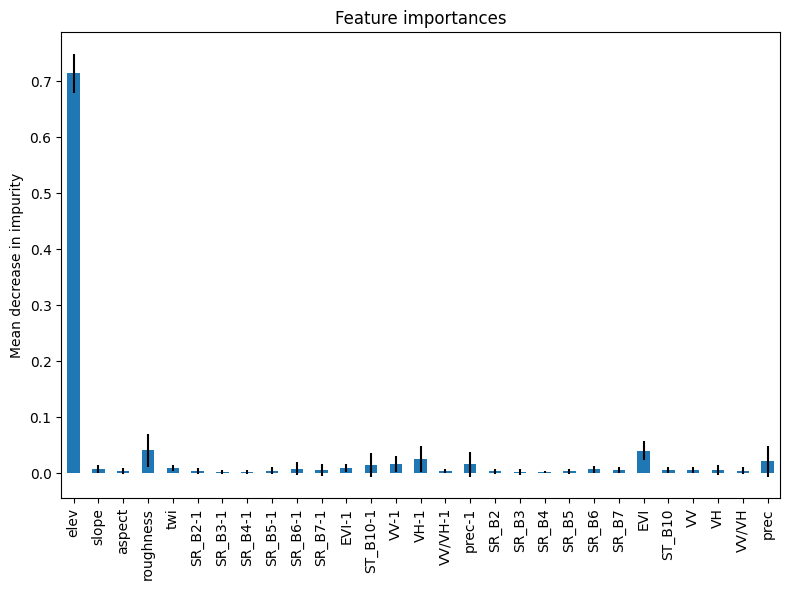

In [70]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=df.iloc[:,1:].columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [71]:
mse = mean_squared_error(Ypred, Ytest)
print("RMSE", math.sqrt(mse))
mae = mean_absolute_error(Ypred, Ytest)
print("MAE", mae)
R_square = r2_score(Ypred, Ytest) 
print('Coefficient of Determination', R_square) 

RMSE 4.000787184902813
MAE 2.3487593701111793
Coefficient of Determination 0.8292409950296955


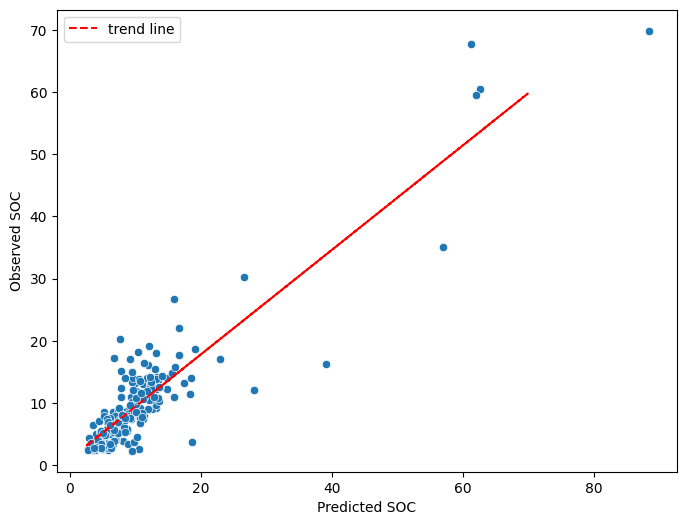

In [72]:
scatterplot=sns.scatterplot(x=np.squeeze(Ypred), y=np.squeeze(Ytest))
Ypred = pd.to_numeric(Ypred, errors='coerce')
Ytest = pd.to_numeric(Ytest, errors='coerce')
z = np.polyfit(Ypred, Ytest, 1)  #Least squares polynomial fit.
p = np.poly1d(z)                           #A one-dimensional polynomial class.
scatterplot.plot(np.squeeze(Ytest), p(np.squeeze(Ytest)), "r--", label='trend line')
# sns.lineplot(x=np.linspace(0, 80, 100), y=x, 'g', label='y=x')
plt.legend()
plt.xlabel("Predicted SOC")
plt.ylabel("Observed SOC")
plt.show()